In [1]:
# import needed modules
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# get adjusted closing prices of 5 selected companies with Quandl
quandl.ApiConfig.api_key = 'YxoLj8ezeNxXnnB4-oKX'
selected = ['CNP', 'F', 'WMT', 'GE', 'TSLA']
data = quandl.get_table('WIKI/PRICES', ticker = selected,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2014-1-1', 'lte': '2016-12-31' }, 
                        paginate=True)
data.head()

,date,ticker,adj_close
None,,,
0,2016-12-30,WMT,67.742045
1,2016-12-29,WMT,67.879254
2,2016-12-28,WMT,67.928257
3,2016-12-27,WMT,68.310482
4,2016-12-23,WMT,68.153672


In [14]:
# reorganise data pulled by setting date as index with
# columns of tickers and their corresponding adjusted prices
clean = data.set_index('date')
table = clean.pivot(columns='ticker')
table.head()

adj_close                                         
ticker            CNP          F         GE    TSLA        WMT
date                                                          
2014-01-02  19.116238  12.726742  24.266002  150.10  71.343743
2014-01-03  19.107861  12.784441  24.248354  149.56  71.108673
2014-01-06  19.132992  12.842140  24.054226  147.00  70.710863
2014-01-07  19.334039  12.677286  24.080698  149.36  70.927850
2014-01-08  19.132992  12.809169  24.010106  151.28  70.367299

In [15]:
# calculate daily and annual returns of the stocks
returns_daily = table.pct_change()
returns_annual = returns_daily.mean() * 250
returns_annual

           ticker
adj_close  CNP       0.091859
           F        -0.007358
           GE        0.095399
           TSLA      0.204873
           WMT      -0.000943
dtype: float64

In [16]:
# get daily and covariance of returns of the stock
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 250
cov_annual

adj_close                                        
ticker                 CNP         F        GE      TSLA       WMT
          ticker                                                  
adj_close CNP     0.040941  0.014076  0.015147  0.017508  0.010534
          F       0.014076  0.052813  0.021476  0.029219  0.011608
          GE      0.015147  0.021476  0.033564  0.022247  0.010747
          TSLA    0.017508  0.029219  0.022247  0.176760  0.012628
          WMT     0.010534  0.011608  0.010747  0.012628  0.032357

In [7]:
# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
sharpe_ratio = []
stock_weights = []

# set the number of combinations for imaginary portfolios
num_assets = len(selected)
num_portfolios = 50000

#set random seed for reproduction's sake
np.random.seed(101)

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    sharpe = returns / volatility
    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

In [20]:
# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

In [21]:
# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(selected):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

In [22]:
# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)
df.head()

,CNP Weight,F Weight,GE Weight,Returns,Sharpe Ratio,TSLA Weight,Volatility,WMT Weight
0,0.261820,0.289335,0.086964,0.040788,0.272835,0.347444,0.149496,0.014437
1,0.283065,0.104199,0.244927,0.104291,0.591821,0.064474,0.176221,0.303335
2,0.195196,0.124019,0.276685,0.079494,0.450830,0.340038,0.176328,0.064062
3,0.120722,0.043415,0.378758,0.118147,0.572448,0.143523,0.206389,0.313581
4,0.434703,0.328493,0.087453,0.058253,0.364128,0.118597,0.159980,0.030755


In [23]:
# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in selected]

# reorder dataframe columns
df = df[column_order]
df.head()

,Returns,Volatility,Sharpe Ratio,CNP Weight,F Weight,WMT Weight,GE Weight,TSLA Weight
0,0.040788,0.149496,0.272835,0.261820,0.289335,0.014437,0.086964,0.347444
1,0.104291,0.176221,0.591821,0.283065,0.104199,0.303335,0.244927,0.064474
2,0.079494,0.176328,0.450830,0.195196,0.124019,0.064062,0.276685,0.340038
3,0.118147,0.206389,0.572448,0.120722,0.043415,0.313581,0.378758,0.143523
4,0.058253,0.159980,0.364128,0.434703,0.328493,0.030755,0.087453,0.118597


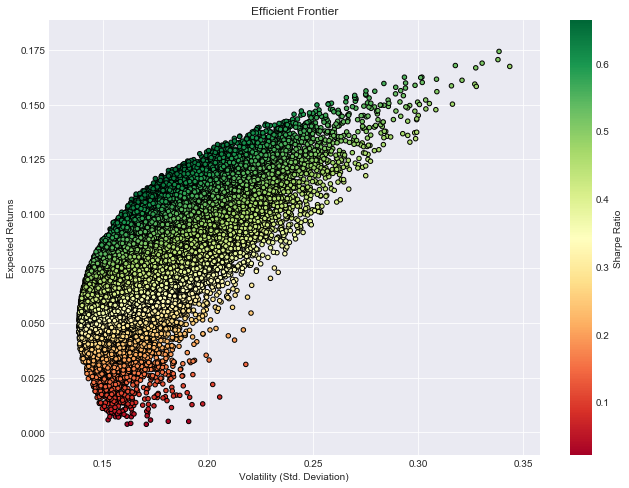

In [24]:
# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(11, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()